In [2]:
!pip uninstall -y timm
!pip install -q "timm==0.9.12"

Found existing installation: timm 1.0.24
Uninstalling timm-1.0.24:
  Successfully uninstalled timm-1.0.24
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.0 MB/s eta 0:00:00


In [1]:
import timm
print(timm.__version__)

0.9.12


In [2]:
!pip install -q transformers>=4.45.0 timm accelerate bitsandbytes
!pip install -q tensorflow-datasets tensorflow-hub
!pip install -q -U bitsandbytes

In [6]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor,AutoConfig
from PIL import Image
import sys

In [8]:
model_id = "openvla/openvla-7b"

In [9]:
from transformers.models.auto.modeling_auto import AutoModelForVision2Seq
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)

try:
    vla = AutoModelForVision2Seq.from_config(config, trust_remote_code=True)
except Exception:
    pass

# Applying the patch globally to the remote class
for module_name, module in sys.modules.items():
    if "modeling_prismatic" in module_name:
        if hasattr(module, "OpenVLAForActionPrediction"):
            setattr(module.OpenVLAForActionPrediction, "_supports_sdpa", True)
            print(f"✅ Globally patched: {module_name}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_prismatic.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openvla/openvla-7b:
- configuration_prismatic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2275: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


modeling_prismatic.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openvla/openvla-7b:
- modeling_prismatic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


✅ Globally patched: transformers_modules.vla_model_local.modeling_prismatic
✅ Globally patched: transformers_modules.openvla.openvla_hyphen_7b.31f090d05236101ebfc381b61c674dd4746d4ce0.modeling_prismatic


In [11]:
save_directory = "/content/vla_model_local/vla_model_local"
print("Loading model and processor from local disk...")
processor = AutoProcessor.from_pretrained(save_directory, trust_remote_code=True)

vla = AutoModelForVision2Seq.from_pretrained(
    save_directory,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    load_in_4bit=True,
    device_map="auto"
)
print("✅ Model loaded and ready for inference.")

Loading model and processor from local disk...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


✅ Model loaded and ready for inference.


In [ ]:
!pip install -q lerobot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.8/758.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 835.4 kB/s eta 0:00:

In [12]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("lerobot/libero_10_image", split="train", streaming=True)

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/379 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/379 [00:00<?, ?it/s]

In [13]:
!pip install -q git+https://github.com/ChaoningZhang/MobileSAM.git

  Preparing metadata (setup.py) ... done


In [14]:
import os
import torch
from mobile_sam import sam_model_registry, SamPredictor

/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_

In [15]:
sam_checkpoint = "mobile_sam.pt"
if not os.path.exists(sam_checkpoint):
    !wget -q https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


In [16]:
# Initialize SAM on GPU
model_type = "vit_t"
mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device="cuda")
sam_predictor = SamPredictor(mobile_sam)

print("✅ MobileSAM loaded and ready.")

✅ MobileSAM loaded and ready.


In [17]:
from PIL import ImageDraw
import numpy as np

In [18]:
def get_sam_guided_image(image_pil, click_point):
    image_np = np.array(image_pil)
    sam_predictor.set_image(image_np)

    # SAM predicts the mask based on 'click'
    masks, _, _ = sam_predictor.predict(
        point_coords=np.array([click_point]),
        point_labels=np.array([1]),
        multimask_output=False,
    )

    # Extract Bounding Box from Mask
    y_indices, x_indices = np.where(masks[0])
    box = [x_indices.min(), y_indices.min(), x_indices.max(), y_indices.max()]

    # Draw Red Box on a copy of the image
    prompted_image = image_pil.copy()
    draw = ImageDraw.Draw(prompted_image)
    draw.rectangle(box, outline="red", width=5)
    return prompted_image, box

In [19]:
it = iter(ds)

for _ in range(200): next(it)
sample = next(it)

In [20]:
instruction = "pick up the alphabet soup" # LIBERO-10 standard instruction
raw_image = sample['observation.images.image']
target_point = [135, 205] # Approximate center of the object in LIBERO frames

# 2. Generate the Guided Image
guided_image, target_box = get_sam_guided_image(raw_image, target_point)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

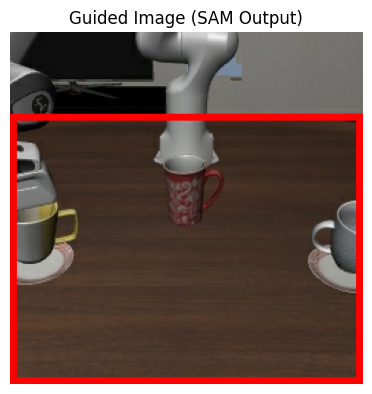

In [21]:
import matplotlib.pyplot as plt

# 1. Display the full guided image (the one with the red box)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(guided_image)
plt.title("Guided Image (SAM Output)")
plt.axis('off')

In [22]:
results = {}
for name, img in [("Vanilla VLA", raw_image), ("VLA + SAM Guidance", guided_image)]:
    inputs = processor(text=instruction, images=img, return_tensors="pt").to("cuda")
    inputs_dict = {k: v for k, v in inputs.items()}

    with torch.no_grad():
        action = vla.predict_action(**inputs_dict, unnorm_key="bridge_orig")
        results[name] = action
    torch.cuda.empty_cache()

In [23]:
# --- REPORTING ---
print("\n" + "="*50)
print(f"REPORT: SEMANTIC GENERALIZATION TEST")
print("="*50)
print(f"Task: {instruction}")
print(f"Expert Action (XYZ): {sample['action'][:3]}")
print("-" * 50)

for mode, act in results.items():
    mse = np.mean((act[:3] - np.array(sample['action'][:3]))**2)
    print(f"{mode} Prediction (XYZ): {act[:3]}")
    print(f"{mode} Mean Squared Error: {mse:.6f}")
    print("-" * 50)


REPORT: SEMANTIC GENERALIZATION TEST
Task: pick up the alphabet soup
Expert Action (XYZ): [0.0, 0.0, -0.39642858505249023]
--------------------------------------------------
Vanilla VLA Prediction (XYZ): [-0.00020879 -0.00042412  0.00703386]
Vanilla VLA Mean Squared Error: 0.054261
--------------------------------------------------
VLA + SAM Guidance Prediction (XYZ): [-0.00020879 -0.00042412  0.00703386]
VLA + SAM Guidance Mean Squared Error: 0.054261
--------------------------------------------------


In [24]:
def apply_aggressive_mask(image_pil, box):
    # Create a translucent red overlay (RGBA)
    overlay = Image.new('RGBA', image_pil.size, (255, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    # 40% opacity red fill
    draw.rectangle(box, fill=(255, 0, 0, 102))

    # Composite the images
    combined = Image.alpha_composite(image_pil.convert('RGBA'), overlay)
    return combined.convert('RGB')

In [25]:
num_samples = 10
results_log = {"Vanilla": [], "Guided": []}
it = iter(ds)

In [26]:
for i in range(num_samples):
    sample = next(it)
    raw_image = sample['observation.images.image']
    expert_action = np.array(sample['action'][:3])

    # A. Vanilla Run
    vanilla_prompt = "pick up the alphabet soup"
    inputs = processor(text=vanilla_prompt, images=raw_image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        v_act = vla.predict_action(**{k:v for k,v in inputs.items()}, unnorm_key="bridge_orig")[:3]
        results_log["Vanilla"].append(np.mean((v_act - expert_action)**2))

    # B. Guided Run (Aggressive Mask + Spatial Prompt)
    target_box = get_sam_guided_image(raw_image, [135, 205])[1] # Reuse your box function
    guided_img = apply_aggressive_mask(raw_image, target_box)
    guided_prompt = "pick up the soup in the highlighted red area"

    inputs_g = processor(text=guided_prompt, images=guided_image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        g_act = vla.predict_action(**{k:v for k,v in inputs_g.items()}, unnorm_key="bridge_orig")[:3]
        results_log["Guided"].append(np.mean((g_act - expert_action)**2))

    torch.cuda.empty_cache()
    if (i+1) % 2 == 0: print(f"Completed {i+1}/{num_samples} frames...")

Completed 2/10 frames...
Completed 4/10 frames...
Completed 6/10 frames...
Completed 8/10 frames...
Completed 10/10 frames...


In [27]:
print("\n" + "="*40)
print("BATCH EXPERIMENT SUMMARY")
print("="*40)
print(f"Vanilla Avg MSE: {np.mean(results_log['Vanilla']):.6f}")
print(f"Guided Avg MSE:  {np.mean(results_log['Guided']):.6f}")
improvement = (np.mean(results_log['Vanilla']) - np.mean(results_log['Guided'])) / np.mean(results_log['Vanilla']) * 100
print(f"Improvement:     {improvement:.2f}%")
print("="*40)


BATCH EXPERIMENT SUMMARY
Vanilla Avg MSE: 0.015868
Guided Avg MSE:  0.015868
Improvement:     0.00%


In [1]:
!cp -r /content/drive/MyDrive/OpenVLAmodel/vla_model_local /content/vla_model_local

In [ ]:
print("Dataset Features:")
print(ds.features)

it = iter(ds)
first_sample = next(it)

print("\nAvailable Keys in a sample:")
print(first_sample.keys())

Dataset Features:
{'observation.images.image': Image(mode=None, decode=True), 'observation.images.wrist_image': Image(mode=None, decode=True), 'observation.state': List(Value('float32'), length=8), 'action': List(Value('float32'), length=7), 'timestamp': Value('float32'), 'frame_index': Value('int64'), 'episode_index': Value('int64'), 'index': Value('int64'), 'task_index': Value('int64')}

Available Keys in a sample:
dict_keys(['observation.images.image', 'observation.images.wrist_image', 'observation.state', 'action', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index'])


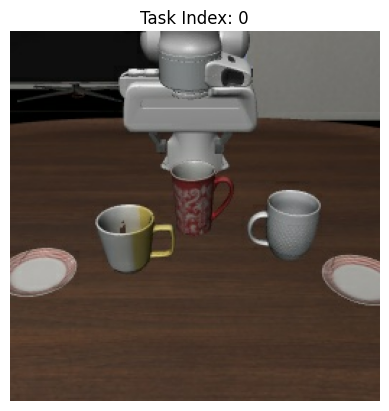

Expert Action for this frame: [0.01607142947614193, 0.0, -0.0, 0.0, 0.0, -0.0, -1.0]


In [ ]:
import matplotlib.pyplot as plt

# Grab the image from our first_sample
sample_img = first_sample['observation.images.image']

plt.imshow(sample_img)
plt.title(f"Task Index: {first_sample['task_index']}")
plt.axis('off')
plt.show()

# Print the action for this specific frame
print(f"Expert Action for this frame: {first_sample['action']}")

In [ ]:
# Install MobileSAM
!pip install -q git+https://github.com/ChaoningZhang/MobileSAM.git

In [ ]:
import os
import torch
from mobile_sam import sam_model_registry, SamPredictor

In [ ]:
# Download weights if not present
sam_checkpoint = "mobile_sam.pt"
if not os.path.exists(sam_checkpoint):
    !wget -q https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt

In [ ]:
# Initialize SAM on GPU
model_type = "vit_t"
mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device="cuda")
sam_predictor = SamPredictor(mobile_sam)

print("✅ MobileSAM loaded and ready.")